In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.integrate import odeint
from scipy import interpolate as interp

In [36]:
#set constants
global adv_BCL_no_flux, adv_BCR_no_flux, diff_BCL_no_flux, diff_BCR_no_flux 
global cL,cR,PL,PR
global alpha
global cinterp
global eps
global coupling_strength
alpha=4.
eps=0.
coupling_strength=1.
L=1.

def get_P(c):
    return np.power(c,alpha)

def u2(y,u):
    u1=u[1]
    u0=u[0]
    uw=get_uw(y)
    u2=cinterp(y)*(u0-uw)
    return np.vstack([u1,u2])

def ubc(ua,ub):
    return np.array([ua[1],ub[1]])

def get_uw(y):
    return -y*(y-1)#-1./3.*y**3.

def get_vW(y):
    vw=y*(y-1.)
    vw[np.where(y>1.)]=0.
    return vw

def get_vE(y,c):
    global cinterp
    cinterp=interp.interp1d(y,c) #make interpolation object from the concentrations
    ug=[get_uw(y),-0.1*np.ones(len(y))] 
    u=solve_bvp(u2,ubc,y,ug,verbose=1)
    u=u.sol(y)[0]
    uw=get_uw(y)
    return coupling_strength*c*(u-uw)
    
def dcdt(c,t):
    dcdt_adv=np.zeros(len(c)) #concentration advective part 
    dcdt_diff=np.zeros(len(c)) #concentration diffusive part 
    v=np.zeros(len(c))
    v+=get_vW(y)
    #v+=get_vE(y,c)
    #advection interior
    for ii in range(1,len(c)-1):
        if v[ii]<=0:
            dcdt_adv[ii]=(c[ii+1]*v[ii+1]-c[ii]*v[ii])/delta
        elif v[ii]>0:
            dcdt_adv[ii]=(c[ii]*v[ii]-c[ii-1]*v[ii-1])/delta
    #BCL:
    if v[0]<=0:
        dcdt_adv[0]=(v[1]*c[1]-c[0]*v[0])/delta
    else:
        dcdt_adv[0]=dcdt_adv_BCL(v[0],c[0])
    #BCR:
    if vw[-1]>=0:
        dcdt_adv[-1]=(v[-1]*c[-1]-c[-2]*v[-2])/delta
    else:
        dcdt_adv[-1]=dcdt_adv_BCR(v[-1],c[-1])
    #non linear diffusion interior
    P=get_P(c)
    dcdt_diff[1:-1]=(P[:-2]-2.*P[1:-1]+P[2:])/delta**2.
    #BCL
    dcdt_diff[0]=dcdt_diff_BCL(P[1],P[0])
    #BCR
    dcdt_diff[-1]=dcdt_diff_BCR(P[-1],P[-2])

    #linear diffusion interior
    dcdt_diff[1:-1]+=eps*(c[:-2]-2.*c[1:-1]+c[2:])/delta**2.
    #BCL
    dcdt_diff[0]+=eps*dcdt_diff_BCL_lin(c[1],c[0])
    #BCR
    dcdt_diff[-1]+=eps*dcdt_diff_BCR_lin(c[-1],c[-2])
    #return sum 
    return -dcdt_adv+dcdt_diff

def dcdt_adv_BCL(vw0,c0):
    if adv_BCL_no_flux==1:
        #no flux condition
        return vw0*c0/delta
    else:
        #fixed C condition
        return (vw0*c0-vwL*cL)/delta

def dcdt_adv_BCR(vw1,c1):
    if adv_BCR_no_flux==1:
        #no flux condition 
        return -vw1*c1/delta
    else:
        #fixed C condition 
        return (vwR*cR-vw1*c1)/delta

def dcdt_diff_BCL(P1,P0):
    if diff_BCL_no_flux==1:
        return (P1-P0)/delta**2
    else:
        return (PL-2*P1+P0)/delta**2

def dcdt_diff_BCR(P1,P2):
    if diff_BCR_no_flux==1:
        return -(P1-P2)/delta**2
    else:
        return (PR-2*P1+P2)/delta**2
    
def dcdt_diff_BCL_lin(C1,C0):
    if diff_BCL_no_flux==1:
        return (C1-C0)/delta**2
    else:
        return (cL-2*C1+C0)/delta**2

def dcdt_diff_BCR_lin(C1,C2):
    if diff_BCR_no_flux==1:
        return -(C1-C2)/delta**2
    else:
        return (cR-2*C1+C2)/delta**2
    
def odeint_substepper(c0,t,dM):#reduces output
    dt=t[1]-t[0]
    C=np.zeros((len(t),len(c0)))
    C[0]=c0
    t_int=np.linspace(0,dM*dt,int(dM))
    for ii in range(1,len(t)):
        temp=odeint(dcdt,C[ii-1],t_int)
        C[ii]=temp[-1]
    return C

In [44]:
#ygrid 
L=2.
delta=0.01
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.1

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=20.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C=odeint_substepper(c0,t,dM)


500.0
0.04
50


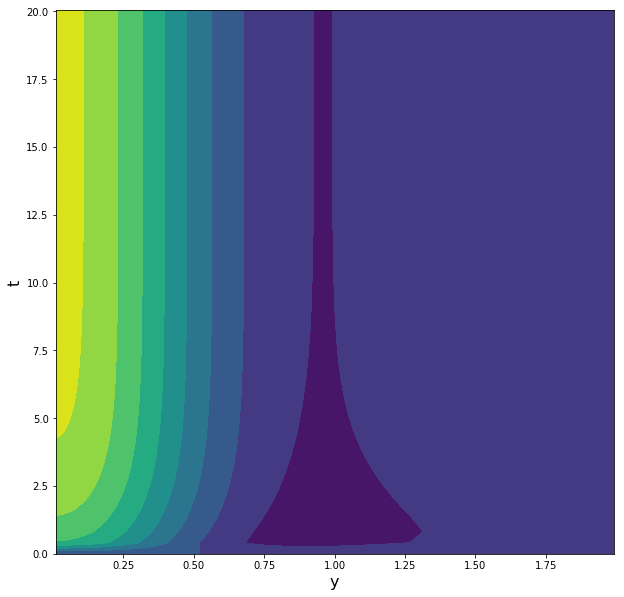

In [45]:
plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

500.0
0.04
50


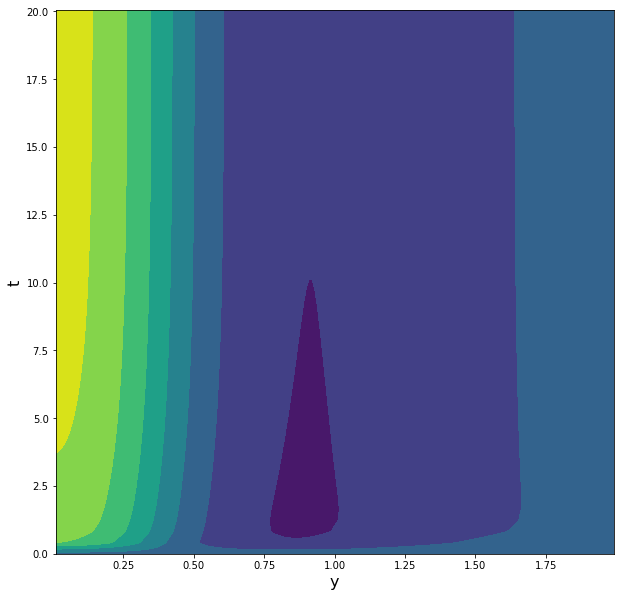

In [47]:
#ygrid 
L=2.
delta=0.01
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.05

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=20.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C1=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C1)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

500.0
0.02
50


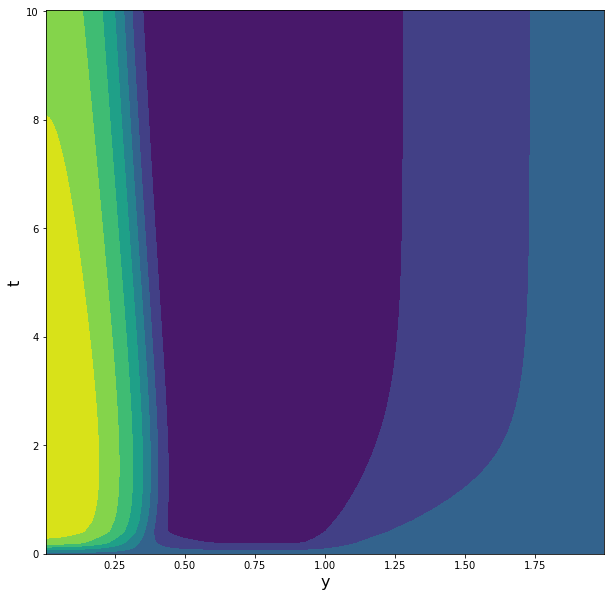

In [51]:
#ygrid 
L=2.
delta=0.005
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.01

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=10.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C2=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C2)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

500.0
0.02
50


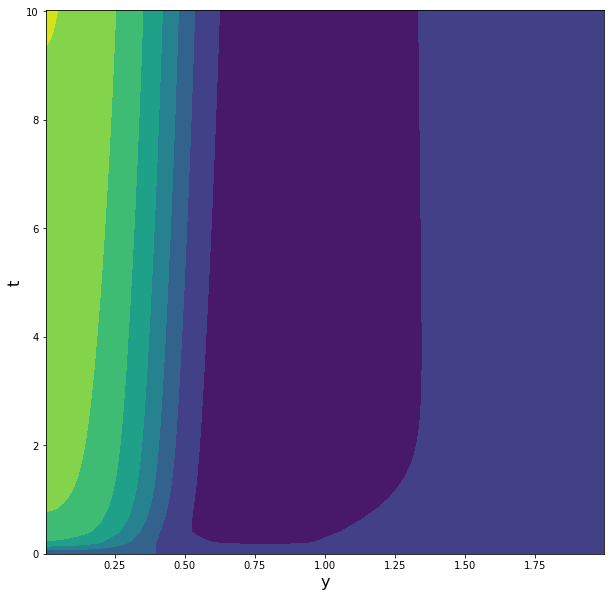

In [53]:
#ygrid 
L=2.
delta=0.005
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.025

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=10.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C3=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C3)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

1000.0
0.01
100


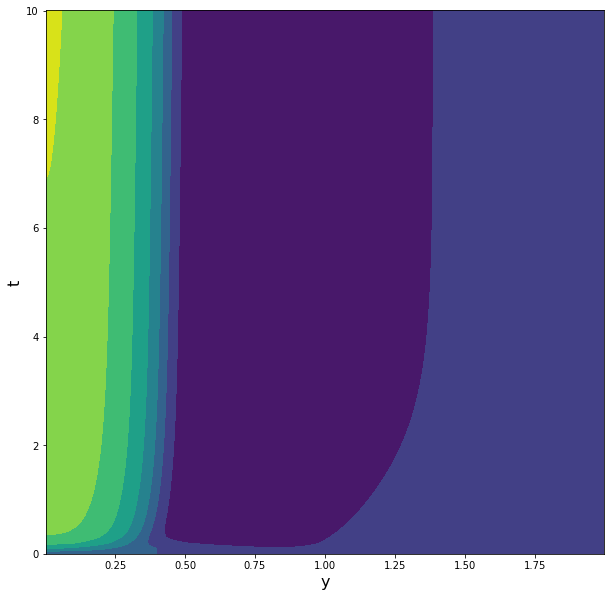

In [54]:
#ygrid 
L=2.
delta=0.0025
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.01

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=10.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C4=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C4)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

1000.0
0.02
100


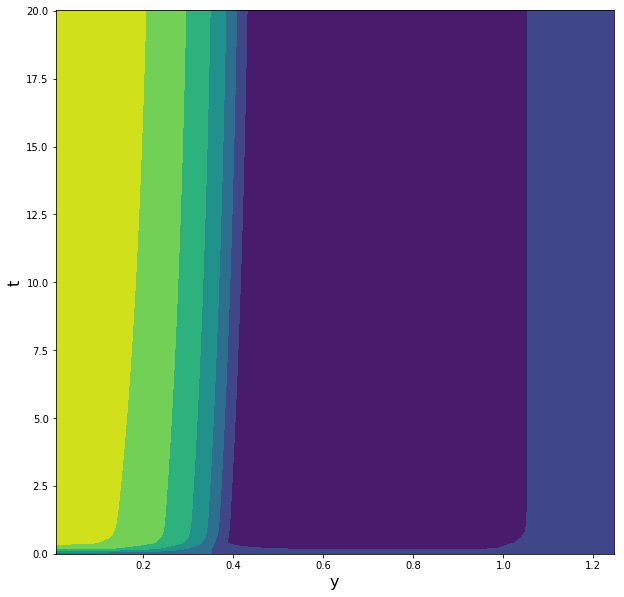

In [59]:
#ygrid 
L=1.25
delta=0.005
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.005

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=20.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C5=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C5)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()

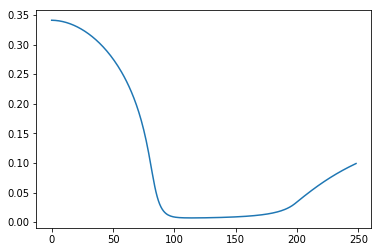

In [63]:
plt.plot(C5[-1])
plt.show()

500.0
0.01
50


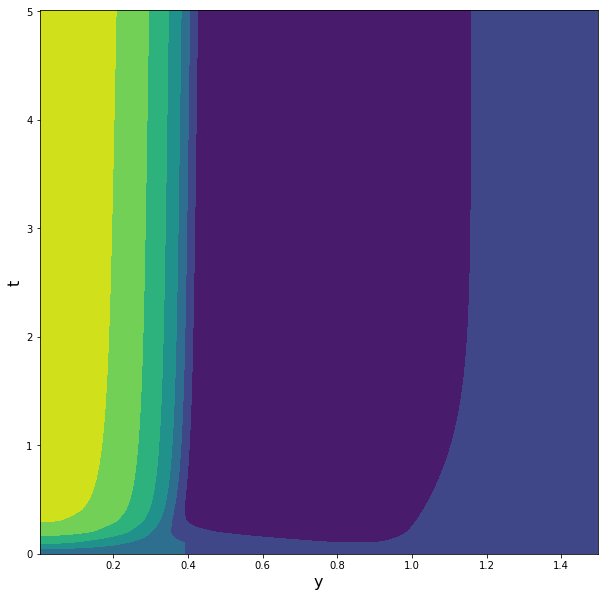

In [67]:
#ygrid 
L=1.5
delta=0.0025
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
#vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

eps=0.005

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=5.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C5=odeint_substepper(c0,t,dM)


plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C5)
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()